# MNIST Tasks

This notebook utilizes a simple neural network containing a single n-task context layer to perform multiple tasks using the MNIST dataset

In [1]:
# Import Tensorflow and Keras layers
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras import Model

import math
import numpy as np
import random

# Utility functions
from utils import idx_load

# Import n-task library
from ntask.atr   import AtrModel, AtrMovingAverage
from ntask.layer import Context
from ntask.model import NTaskModel

# TEMP: Remove when model prototypes are done
from collections import defaultdict
import sklearn

%load_ext autoreload

In [2]:
# Reload Python modules
%autoreload 2

In [3]:
def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [4]:
from collections import defaultdict
import sklearn
from ntask.utils import display_progress, plotFrames

class NTaskModel2(Model):
    def __init__(self, *args, loss_fn=None, optimizer=None, **kwargs):
        super(NTaskModel2, self).__init__(*args, **kwargs)
        
        #! A temporary way to store things...
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        
        # A list of all context layers
        self.context_layers = []
        
        # Debugging
        self.atr_frames = {}
        
        # Misc
        self.total_epochs = 0
        
        # Create the context layer lookup table
        self._create_context_layer_index_list()
        
        
    def compile(self, *args, **kwargs):
        super(NTaskModel2, self).compile(*args, **kwargs)
        self.create_context_layer_index_list()
        
    
    def _create_context_layer_index_list(self):
        """
        Create a lookup table for context layers.
        This is required to efficiently update each context layer's loss information
        """
        self.context_layers = [i for i, layer in enumerate(self.layers) if isinstance(layer, Context)]
        self.atr_frames = {i: defaultdict(dict) for i in self.context_layers}
        
        
    def _calc_context_loss(self, context_layer_idx, gradients):
        """
        IMPORTANT: 
        1) Assumes no use of activation function on Ntask layer
        2) Assumes that the layer following the Ntask layer:
            a) Is a Dense layer
            b) Is using bias 
               — ex: Dense(20, ... , use_bias=True) 
               — note Keras Dense layer uses bias by default if no value is given for use_bias param
        3) Assumes index of the next layer's gradient is known within the gradients list returned from gradient tape in a tape.gradient call
        4) If the above points aren't met, things will break and it may be hard to locate the bugs
        """
        # From the delta rule in neural network math
        delta_at_next_layer = gradients[context_layer_idx + 1]
        transpose_of_weights_at_next_layer = tf.transpose(self.layers[context_layer_idx + 1].get_weights()[0])
        
        # Calculate delta at n-task layer
        context_delta = np.dot(delta_at_next_layer, transpose_of_weights_at_next_layer).astype(np.float)
        
        return context_delta
        
    
    def _custom_forward_pass(self, x_train, y_train, batch_size):
        """
        This is the training forward pass for an entire epoch

        !!!!! Read through this code as it is a nonstandard training forward pass ( different than model.fit() )
        & NOTE that this does not apply the gradients ie. this does not do a weight update/learn

        """
        
        epoch_grads = []
        
        # Calculate the total number of batches that need to be processed
        num_batches = int(np.ceil(len(x_train) / batch_size))
        
        # Tensorflow 2 style training -- info can be found here: https://www.tensorflow.org/guide/effective_tf2 
        # This is similar to model.fit(), however this is a custom training loop -- ie. it does things differently than model.fit()
        # look at each input and label (there are 4 for the logic gates)
        for start, end in ((s*batch_size, (s + 1)*batch_size) for s in range(num_batches)):
            
            # Slice into batch
            x = x_train[start:end]
            y = y_train[start:end]
            
            with tf.GradientTape() as tape:
                predictions = self(x, training=True) # Forward pass
                loss = self.loss_fn(y, predictions) # Get the loss
            
            # Extract the gradients for the loss of the current sample
            gradients = tape.gradient(loss, self.trainable_variables)
            
            # Add up the total gradients
            epoch_grads.append(gradients)
            
            for context_layer_idx in self.context_layers:
                self.layers[context_layer_idx].add_context_loss(self._calc_context_loss(context_layer_idx, gradients))
                
        for context_layer_idx in self.context_layers:
            print(self.layers[context_layer_idx].context_loss)
                
        return epoch_grads
                
        
    def fit(self, x_train, y_train, n_epochs=1, shuffle=True, progress=False, explicit_contexts=None, batch_size=None, verbose=1):
        
        # Explicit context learning: specify the contexts for ecah of the layers. None=dynamic
        if explicit_contexts is not None:
            if len(explicit_contexts) != len(self.context_layers):
                raise ValueError("Length of explicit contexts does not match the number of context layers")
            for i, idx in enumerate(self.context_layers):
                if explicit_contexts[i] is not None:
                    self.layers[idx].set_hot_context(explicit_contexts[i])
        else:
            explicit_contexts = [None for x in self.context_layers]
        
        # Determine the default batch size
        if batch_size is None:
            batch_size = len(x_train)
        
        # Shuffle the dataset
        x_train, y_train = sklearn.utils.shuffle(x_train, y_train)
        
        epoch = 0
        while epoch < n_epochs:
            
            # DEBUG; Display progress
            if progress:
                display_progress(epoch / n_epochs, title=str([self.layers[i].get_hot_context() for i in self.context_layers]))
            
            # Reset the context loss
            for idx in self.context_layers:
                self.layers[idx].context_loss = 0.0
            
            # Perform a forward pass
            epoch_grads = self._custom_forward_pass(x_train, y_train, batch_size)
            
            # Iterate backwards over the context layers. If a context switch occurs, don't check any other layers
            switched = False
            for i in range(len(self.context_layers) - 1, -1, -1):
                # Fetch the context layer
                context = self.layers[self.context_layers[i]]
                
                # Check if explicit context learning for this layer is set
                dynamic_switch = explicit_contexts[i] is None
                
                # Update the layer and indicate if a task switch occurred
                if context.update_and_switch(dynamic_switch, verbose=verbose) & Context.RESULT_SWITCHED:
                    # A task switch occurred, don't update any other layers/weights
                    switched = True
                    break
            
            # If no task switch occurred, we can update the weights of the network
            if not switched:
                epoch += 1
                self.total_epochs += 1
                
                # Apply the gradients
                for grads in epoch_grads:
                    self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

                for idx in self.context_layers[::-1]:
                    for t in range(self.layers[idx].num_tasks):
                        self.atr_frames[idx][t][self.total_epochs] = self.layers[idx].atr_model.atr_values[t]
                        
                # Reshuffle the dataset
                x_train, y_train = sklearn.utils.shuffle(x_train, y_train)
                        
                        
    def get_contexts(self):
        """Get the hot context from all context layers"""
        return [self.layers[i].get_hot_context() for i in self.context_layers]
            
                    
    def plot_atr_values(self):
        for idx in self.context_layers:
            n = self.layers[idx].num_tasks
            plotFrames(f"ATR Values for Context Layer {idx}", *self.atr_frames[idx].values(), labels=[i for i in range(n)])

## Dataset

In [5]:
# Training images
training_images = idx_load("datasets/mnist/train-images.idx3-ubyte")
training_images.shape

(60000, 28, 28)

In [6]:
# Training labels
training_labels = idx_load("datasets/mnist/train-labels.idx1-ubyte")
training_labels.shape

(60000,)

In [7]:
# Testing images
testing_images = idx_load("datasets/mnist/t10k-images.idx3-ubyte")
testing_images.shape

(10000, 28, 28)

In [8]:
# Testing labels
testing_labels = idx_load("datasets/mnist/t10k-labels.idx1-ubyte")
testing_labels.shape

(10000,)

In [9]:
# Normalize the datasets
training_images = training_images.reshape(len(training_images), 28*28) / 255.0
testing_images  = testing_images.reshape(len(testing_images), 28*28) / 255.0

### Loss Function

In [10]:
def loss_fn(labels, predictions):
    return tf.keras.losses.binary_crossentropy(y_true=labels, y_pred=predictions)

## Simple MNIST Model

This model demonstrates a basic model to learn the MNIST dataset.

This model successfully learns the MNIST dataset using SGD with a learn rate of ~1e-1 or Adam with 1e-4

In [10]:
set_seed(5)

### Optimizer

In [11]:
optimizer = tf.keras.optimizers.SGD(1e-1)

### Model

In [12]:
x_train = training_images[:1000]
y_train = training_labels[:1000]

x_test = testing_images
y_test = testing_labels

In [13]:
inp = Input((28*28))
# x = Flatten()(inp)
x = Dense(128, activation="relu")(inp)
x = Dense(10, activation="softmax")(x)

In [14]:
model = Model(inputs=inp, outputs=x)

In [15]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    metrics=['accuracy']
)

### Training & Evaluation

In [16]:
model.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test), verbose=0)

In [17]:
result = (np.argmax(model.predict(x_train), axis=1) == y_train).sum()
print(f"{result}/{len(y_train)}; Accuracy: {100*result/len(y_train):.2f}%")

883/1000; Accuracy: 88.30%


In [18]:
result = (np.argmax(model.predict(x_test), axis=1) == y_test).sum()
print(f"{result}/{len(y_test)}; Accuracy: {100*result/len(y_test):.2f}%")

7845/10000; Accuracy: 78.45%


___

## n-task Model Only

This section demonstrates the learning capability of the n-task model without any context layers or switching mechanisms. The architecture is equivalent to that of the previous model

In [11]:
set_seed(5)

### Optimizer

In [12]:
optimizer = tf.keras.optimizers.SGD(1e-4)

### Model

In [13]:
x_train = training_images[:1000]
y_train = training_labels[:1000]

x_test = testing_images
y_test = testing_labels

In [14]:
inp = Input((28*28,))
# x = Flatten()(inp)
x = Dense(128, activation="relu")(inp)
x = Context(AtrMovingAverage(1, task_switch_threshold=-0.02))(x)
x = Dense(10, activation="softmax")(x)

In [15]:
model = NTaskModel2(inputs=inp, outputs=x, loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=optimizer)

### Training and Validation

In [16]:
model.fit(x_train, y_train, 20, verbose=0, batch_size=None, explicit_contexts=[0])

tf.Tensor(1.3102797158542693e-07, shape=(), dtype=float64)
tf.Tensor(1.3103928480535491e-07, shape=(), dtype=float64)
tf.Tensor(1.310505735636298e-07, shape=(), dtype=float64)
tf.Tensor(1.3106177470436887e-07, shape=(), dtype=float64)
tf.Tensor(1.31073152480464e-07, shape=(), dtype=float64)
tf.Tensor(1.3108433838862448e-07, shape=(), dtype=float64)
tf.Tensor(1.3109561828938022e-07, shape=(), dtype=float64)
tf.Tensor(1.3110683803519473e-07, shape=(), dtype=float64)
tf.Tensor(1.3111824334898044e-07, shape=(), dtype=float64)
tf.Tensor(1.3112951552634913e-07, shape=(), dtype=float64)
tf.Tensor(1.3114090781490436e-07, shape=(), dtype=float64)
tf.Tensor(1.3115220724999705e-07, shape=(), dtype=float64)
tf.Tensor(1.3116339948959964e-07, shape=(), dtype=float64)
tf.Tensor(1.3117472972722107e-07, shape=(), dtype=float64)
tf.Tensor(1.3118604753820043e-07, shape=(), dtype=float64)
tf.Tensor(1.3119726499449674e-07, shape=(), dtype=float64)
tf.Tensor(1.3120852848010661e-07, shape=(), dtype=float64)


In [17]:
result = (np.argmax(model.predict(x_train), axis=1) == y_train).sum()
print(f"{result}/{len(y_train)}; Accuracy: {100*result/len(y_train):.2f}%")

128/1000; Accuracy: 12.80%


In [18]:
result = (np.argmax(model.predict(x_test), axis=1) == y_test).sum()
print(f"{result}/{len(y_test)}; Accuracy: {100*result/len(y_test):.2f}%")

1164/10000; Accuracy: 11.64%


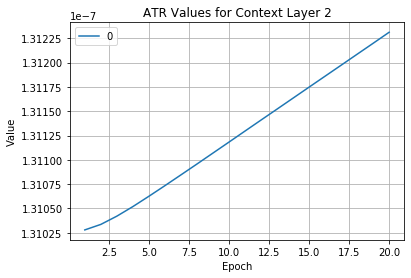

In [19]:
model.plot_atr_values()

___

## n-task: x, 9 - x

Task 1: Determine the value in the image. <br>|
Task 2: Determine the value in the image and subtract it from 9

In [227]:
set_seed(5)

### Optimizer

In [228]:
optimizer = tf.keras.optimizers.SGD(1e-1)

### Model

In [229]:
x_train = training_images[:1000]
y_train = training_labels[:1000]
y1_train = y_train
y2_train = 9 - y_train

x_test = testing_images
y_test = testing_labels
y1_test = y_test
y2_test = 9 - y_test

In [230]:
inp = Input((28*28,))
# x = Flatten()(inp)
x = Dense(128, activation="relu")(inp)
x = Context(AtrMovingAverage(2, task_switch_threshold=-0.02))(x)
x = Dense(10, activation="softmax")(x)

In [231]:
model = NTaskModel(inputs=inp, outputs=x, loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=optimizer)

### Training and Validation

In [232]:
for cycle in range(4):
    for context, y in enumerate([y1_train, y2_train]):
        print("Context:", context)
        model.fit(x_train, y, 75, verbose=1, batch_size=1, explicit_contexts=[context])
        assert model.layers[2].get_hot_context() == context

Context: 0
Context: 1
Context: 0
Context: 1
Context: 0
Context: 1
Context: 0
Context: 1


In [233]:
for context, y in enumerate([y1_train, y2_train]):
    model.layers[2].set_hot_context(context)
    result = (np.argmax(model(x_train), axis=1) == y).sum()
    print(f"{result}/{len(y)}; Accuracy: {100*result/len(y):.2f}%")

983/1000; Accuracy: 98.30%
987/1000; Accuracy: 98.70%


In [234]:
for context, y in enumerate([y1_test, y2_test]):
    model.layers[2].set_hot_context(context)
    result = (np.argmax(model(x_test), axis=1) == y).sum()
    print(f"{result}/{len(y)}; Accuracy: {100*result/len(y):.2f}%")

8858/10000; Accuracy: 88.58%
8846/10000; Accuracy: 88.46%


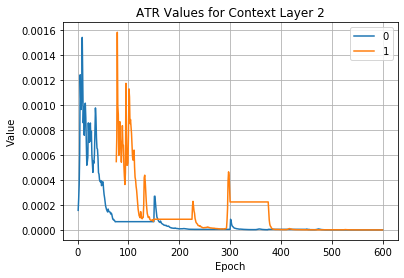

In [235]:
model.plot_atr_values()

___

## MNIST: n-task

### Optimizer

In [379]:
optimizer = tf.keras.optimizers.SGD(1e-4)

### Model

In [380]:
x_train = training_images[:1000]
y_train = training_labels[:1000]

y1_train = np.array([int(i % 3 == 0) for i in y_train]) # Divisible by 3
y2_train = np.array([int(i % 2 == 0) for i in y_train]) # Even
y3_train = np.array([int(i % 2 == 1) for i in y_train]) # Odd

In [381]:
x_test = testing_images
y_test = testing_labels

y1_test = np.array([int(i % 3 == 0) for i in y_test]) # Divisible by 3
y2_test = np.array([int(i % 2 == 0) for i in y_test]) # Even
y3_test = np.array([int(i % 2 == 1) for i in y_test]) # Odd

In [382]:
random.seed(5)
tf.random.set_seed(5)

In [383]:
# inp = Input((28,28))
# x = Flatten()(inp)
inp = Input((28*28,))
x = Dense(2048, activation="relu")(inp)
x = Context(AtrMovingAverage(num_tasks=1, task_switch_threshold=-0.02))(x)
x = Dense(1, activation="sigmoid")(x)

In [384]:
model = NTaskModel2(inputs=inp, outputs=x, loss_fn=loss_fn, optimizer=optimizer)
# model = Model(inputs=inp, outputs=x)
# model.compile(loss=loss_fn, optimizer=optimizer)

In [385]:
for cycle in range(1):
    for i, y in enumerate([y1_train]):
        print(i)
        model.fit(x_train, y, 100, verbose=0, batch_size=32, explicit_contexts=[i])

0


In [386]:
model.predict(x_train)

array([[0.36761928],
       [0.4199247 ],
       [0.40151417],
       [0.37263757],
       [0.36686993],
       [0.36947942],
       [0.39468235],
       [0.4219528 ],
       [0.38158232],
       [0.36529696],
       [0.38845012],
       [0.4080037 ],
       [0.38494495],
       [0.42446116],
       [0.37241495],
       [0.38248748],
       [0.38081726],
       [0.3538569 ],
       [0.4631479 ],
       [0.41913682],
       [0.38174725],
       [0.41149223],
       [0.43985212],
       [0.37703764],
       [0.4001965 ],
       [0.369301  ],
       [0.38105702],
       [0.41085693],
       [0.3723886 ],
       [0.43257394],
       [0.38811737],
       [0.36603785],
       [0.46171194],
       [0.3521932 ],
       [0.3909344 ],
       [0.40374854],
       [0.35123712],
       [0.43378812],
       [0.3945792 ],
       [0.4231755 ],
       [0.35725325],
       [0.35135645],
       [0.39940447],
       [0.4050997 ],
       [0.41596556],
       [0.38244992],
       [0.39590204],
       [0.416

In [387]:
for context, y in enumerate([y_train]):
#     model.layers[model.context_layers[0]].set_hot_context(context)
    result = (np.round(model.predict(x_train).flatten()).astype(int) == y).sum()
    print(f"Context({context}): {result}/{len(y)}; Accuracy: {100*result/len(y):.2f}%")

Context(0): 97/1000; Accuracy: 9.70%


In [45]:
model.plot_atr_values()

In [139]:
model(x_train[0:1])

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.49238953]], dtype=float32)>

In [104]:
y_train[0:1]

array([5])

In [236]:
correct = np.zeros(3)
for i, y in enumerate([y1_train, y2_train, y3_train]):
    model.layers[2].set_hot_context(i)
    result = np.round(model(x_test)).astype(int).flatten()
    correct[i] = np.sum(result == y)/len(y)
print(correct)

[0. 0. 0.]


/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """


In [ ]:
model.layers[2].set_hot_context(0)

In [106]:
# Evaluate doesn't work. Hmmm...
model.evaluate(x_test, y_test)

16/16 [==============================] - 0s 2ms/step - loss: 1.6460 - accuracy: 0.8280


[1.6459522247314453, 0.828000009059906]

In [123]:
model(np.array([x_test[0]]))

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[9.9694675e-01, 6.5245154e-10, 1.3429130e-04, 1.3306305e-07,
        6.1000824e-06, 7.7564758e-04, 3.3671377e-06, 3.8232724e-06,
        2.1278865e-03, 2.0759178e-06]], dtype=float32)>

In [122]:
y_test[0]

0